In [ ]:
# Embedding space of sonar -> Single and variable length input 
# Embedding space of codec -> Single and variable length input

In [3]:
import torch 
import torchaudio
from matplotlib import pyplot as plt
from sonar.inference_pipelines.speech import SpeechToEmbeddingModelPipeline
from IPython.display import Audio, display

In [4]:
inp, sr = torchaudio.load("/data/tagesschau/audio/1/audio.wav")
inp.shape, sr

(torch.Size([2, 47578802]), 48000)

In [5]:
info = torchaudio.info("/data/tagesschau/audio/1/audio.wav")
print(info)

AudioMetaData(sample_rate=48000, num_frames=47578802, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [6]:
down_sample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
low_wave=down_sample(inp)

In [52]:
s2vec_model = SpeechToEmbeddingModelPipeline(encoder="sonar_speech_encoder_deu", device=torch.device("cuda"))

: 

In [51]:
out = s2vec_model.predict([low_wave[:,:48000*10]])
out.shape

torch.Size([1, 1024])

In [2]:
# Testing the encodec

from transformers import EncodecModel, AutoProcessor

In [28]:
device = torch.device("cuda")
encodec = EncodecModel.from_pretrained("facebook/encodec_48khz")
encodec.to(device)
processor = AutoProcessor.from_pretrained("facebook/encodec_48khz")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [77]:
inputs = processor(raw_audio=inp[:,:sr*15], sampling_rate=processor.sampling_rate, return_tensors="pt")

In [78]:
inputs = {k:v.to(device) for k,v in inputs.items()}
inputs

{'padding_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'input_values': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')}

In [79]:
output = encodec.encode(**inputs)
output

EncodecEncoderOutput(audio_codes=tensor([[[[ 442,  442,  442,  ...,  383,  920,  844],
          [ 989,  989,  989,  ...,  853,  321,  170]]],


        [[[ 707, 1017,  324,  ...,  462,  282,  536],
          [ 600,  590,   59,  ...,  281,  398,  784]]],


        [[[ 980,  324,  418,  ...,  418,  438,  866],
          [ 647,   13,  281,  ...,  222,  590,  590]]],


        ...,


        [[[ 987,  516,  947,  ...,  930,  718,  920],
          [ 778,  835,  283,  ...,  673,  446,  601]]],


        [[[ 617,   66,  248,  ...,   34,  968,  195],
          [ 138,  463,  353,  ...,  964,  664,  180]]],


        [[[ 455,  439,  126,  ...,  214,  214,  214],
          [ 402,  402,  885,  ...,  882,  882,  882]]]], device='cuda:0'), audio_scales=[tensor([[[0.0228]]], device='cuda:0'), tensor([[[0.0727]]], device='cuda:0'), tensor([[[0.1122]]], device='cuda:0'), tensor([[[0.1040]]], device='cuda:0'), tensor([[[0.1554]]], device='cuda:0'), tensor([[[0.1277]]], device='cuda:0'), tensor([[[0.121

In [80]:
output.audio_codes = output.audio_codes.to("cpu")
output.audio_codes.shape, output.audio_codes.device, len(output.audio_scales)

(torch.Size([16, 1, 2, 150]), device(type='cpu'), 16)

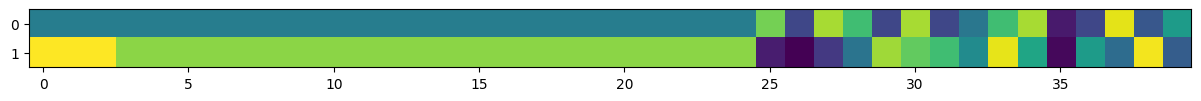

In [81]:
plt.figure(figsize=(15,15))
plt.imshow(output.audio_codes[0, 0, :, :40])

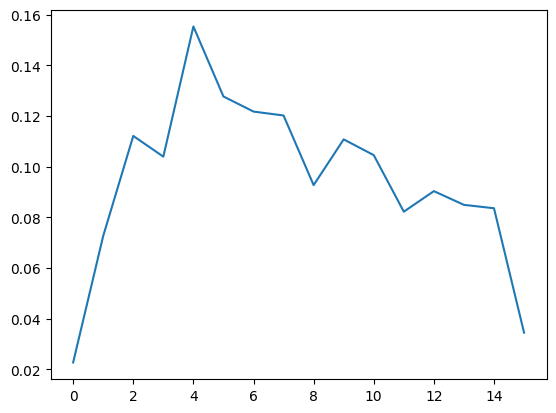

In [83]:
plt.plot([i.item() for i in output.audio_scales])